In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import os
import copy
import matplotlib.colors as colors
import matplotlib.cbook as cbook
import cmocean as cmo
import matplotlib.pyplot as plt
import xarray as xr
import warnings
import cmocean
warnings.filterwarnings("ignore")

from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER

cwd=os.getcwd()

In [2]:
def sort_longitude(_x, lon_min=-180.):
    if lon_min is None:
        return _x
    lon_max=lon_min + 360.

    x = _x.copy()

    for lon in ['xh', 'xq', 'lon']:
        try:
            lon = x[lon]
            if lon.min() < lon_min:
                lon = xr.where(lon<lon_min, lon+360, lon)
                lon = xr.where(lon>lon_max, lon-360, lon)
            else:
                lon = xr.where(lon>lon_max, lon-360, lon)
                lon = xr.where(lon<lon_min, lon+360, lon)   
            x[lon.name] = lon.copy()
            
            x = x.sortby(lon.name)
        except:
            pass
    return x

In [71]:
#WOA18
max_depth = 749.9
ds = sort_longitude(xr.open_dataset('/vast/pp2681/WOA/woa_1981_2010.nc', decode_times=False).isel(time=0), lon_min=-300.)
dz_obs = xr.DataArray(np.diff(ds.depth_bnds).squeeze(), dims=['depth'], coords={'depth':ds.depth})
mask_obs = xr.where(np.isnan(ds.t_an), np.nan, 1.).sel(depth=slice(None,max_depth)).sum('depth')
mask_obs = xr.where(mask_obs == mask_obs.max(), 1., np.nan)

obs = mask_obs * (ds.t_an * dz_obs).sel(depth=slice(None,max_depth)).sum('depth') / dz_obs.sel(depth=slice(None,max_depth)).sum('depth')
obs_sst = ds.t_an.isel(depth=1)

In [61]:
dz_obs.sel(depth=slice(None,max_depth)).sum('depth')

<xarray.DataArray ()> Size: 4B
array(725., dtype=float32)

In [62]:
# EN4
max_depth = 749.9
ds = sort_longitude(xr.open_mfdataset('/vast/pp2681/EN4_dataset/annual/*.nc', decode_times=True).sel(time=slice('1981','2010')), lon_min=-300.).mean('time').compute()
ds = ds.interp(lat=obs.lat, lon=obs.lon)

dz_obs = xr.DataArray(np.diff(ds.depth_bnds).squeeze(), dims=['depth'], coords={'depth':ds.depth})
mask_obs = xr.where(np.isnan(ds.temperature), np.nan, 1.).sel(depth=slice(None,max_depth)).sum('depth')
mask_obs = xr.where(mask_obs == mask_obs.max(), 1., np.nan)

obs_en4 = mask_obs * ((ds.temperature - 273.15) * dz_obs).sel(depth=slice(None,max_depth)).sum('depth') / dz_obs.sel(depth=slice(None,max_depth)).sum('depth')
obs_sst_en4 = (ds.temperature - 273.15).isel(depth=0)

In [53]:
dz_obs.sel(depth=slice(None,max_depth)).sum('depth')

<xarray.DataArray ()> Size: 4B
array(725.1709, dtype=float32)

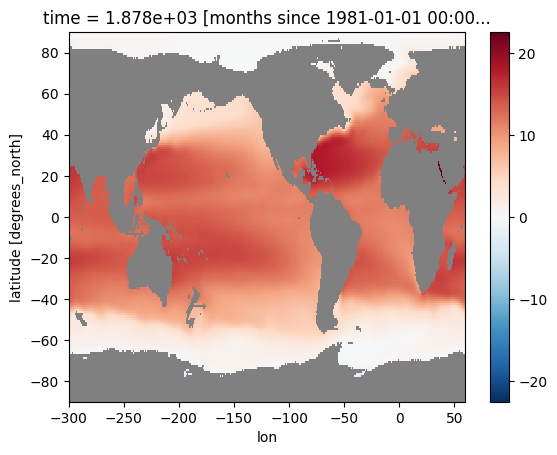

In [54]:
obs.plot()
plt.gca().set_facecolor('gray')

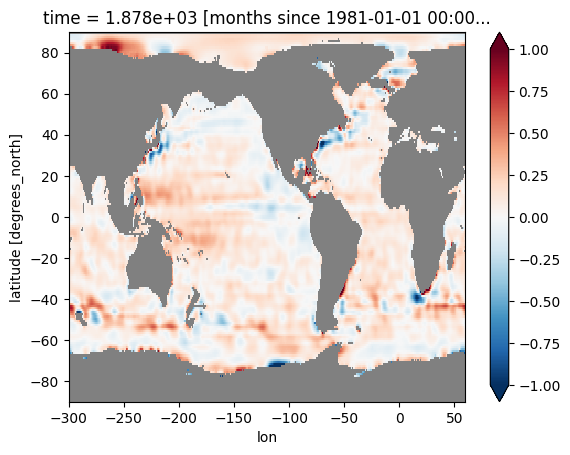

In [59]:
(obs-obs_en4).plot(vmin=-1)
plt.gca().set_facecolor('gray')

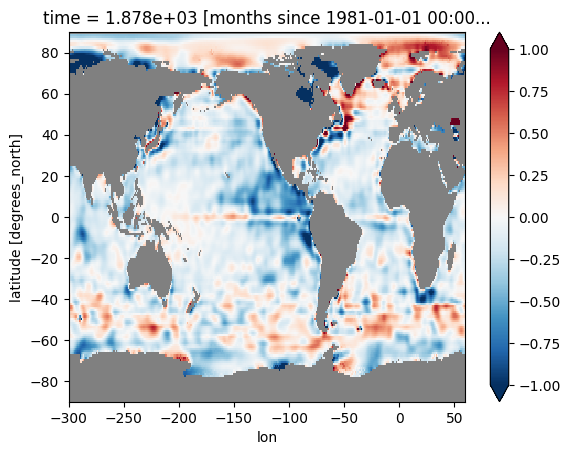

In [74]:
(obs_sst-obs_sst_en4).plot(vmin=-1)
plt.gca().set_facecolor('gray')

In [77]:
param = xr.open_dataset('/home/pp2681/global-runs/data/ocean_static.nc').isel(time=0)

In [78]:
import xesmf as xe

coords_in = xr.Dataset()
coords_in['lon'] = param.geolon
coords_in['lat'] = param.geolat
coords_in['lon_b'] = param.geolon_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})
coords_in['lat_b'] = param.geolat_c.pad({'yq':(1,0)}, mode='symmetric').pad({'xq':(1,0)}, mode='wrap').drop_vars({'xq','yq'})

coords_out = xr.Dataset()
coords_out['lon'] = obs.lon
coords_out['lat'] = obs.lat
# This is one-degree grid
coords_out['lon_b'] = xr.DataArray((obs.lon + 0.5).values, dims='lon_b').pad({'lon_b':(1,0)}, mode='wrap')
coords_out['lat_b'] = xr.DataArray((obs.lat + 0.5).values, dims='lat_b').pad({'lat_b':(1,0)}, mode='symmetric')

regridder_nearest = xe.Regridder(coords_in, coords_out, "nearest_s2d", ignore_degenerate=True, periodic=True)
regridder_conserv = xe.Regridder(coords_in, coords_out, "conservative", ignore_degenerate=True, periodic=True)
#regridder_conserv = xe.Regridder(coords_in, coords_out, "conservative_normed", ignore_degenerate=True, periodic=True)

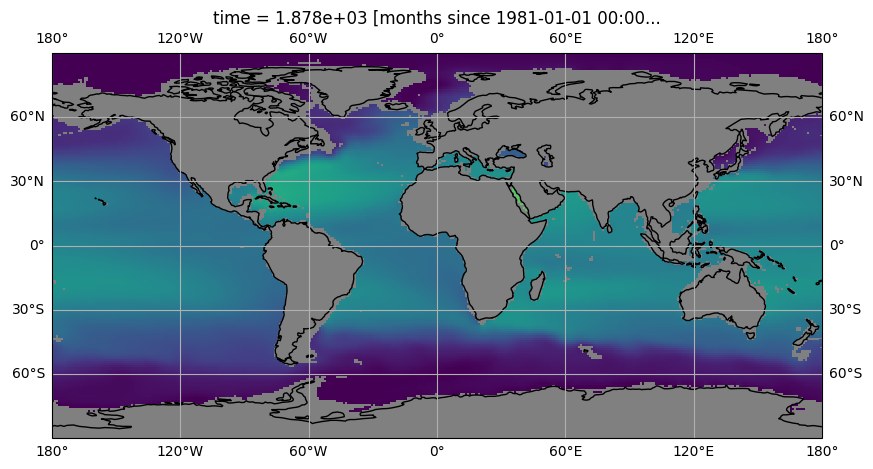

In [79]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
obs.plot.pcolormesh(ax=ax, rasterized=True, cmap='viridis', vmin=0, vmax=30, add_colorbar=False)
ax.gridlines(draw_labels=True)
ax.coastlines()
ax.set_facecolor('gray')
ax.set_ylim([-90,90])
plt.savefig('test1.pdf')

In [80]:
ds = xr.open_mfdataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/*annual_z*nc', parallel=True, combine='nested', compat='no_conflicts', concat_dim='time')

In [81]:
dz = xr.DataArray(np.diff(ds.z_i), dims=['z_l'], coords={'z_l': ds.z_l})

In [82]:
dz.sel(z_l=slice(None,max_depth)).sum()

<xarray.DataArray ()> Size: 8B
array(750.)

In [83]:
mask = xr.where(np.isnan(ds.thetao.isel(time=0)), np.nan, 1.).sel(z_l=slice(None,max_depth)).sum('z_l')
mask = xr.where(mask == mask.max(), 1., np.nan)

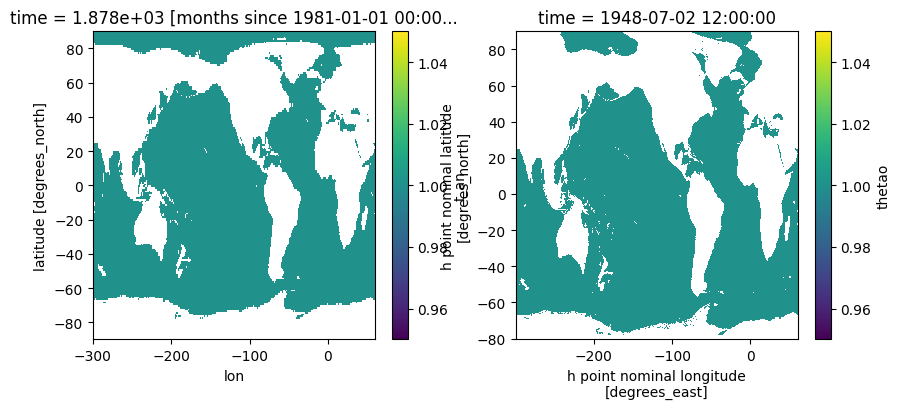

In [84]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
mask_obs.plot()

plt.subplot(1,2,2)
mask.plot()

In [85]:
time_range = slice('1981', '2007')
#time_range = slice('2003','2017')

ds = xr.open_mfdataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/unparameterized/*annual_z*nc', parallel=True, combine='nested', compat='no_conflicts', concat_dim='time')
control = mask * (dz * ds.thetao).sel(z_l=slice(None,max_depth)).sel(time=time_range).mean('time').sum('z_l').compute() / max_depth

ds = xr.open_mfdataset('/scratch/js15017/OM4_storage/CORE-AIF-runs/ANN/*annual_z*nc', parallel=True, combine='nested', compat='no_conflicts', concat_dim='time')
ann = mask * (dz * ds.thetao).sel(z_l=slice(None,max_depth)).sel(time=time_range).mean('time').sum('z_l').compute() / max_depth

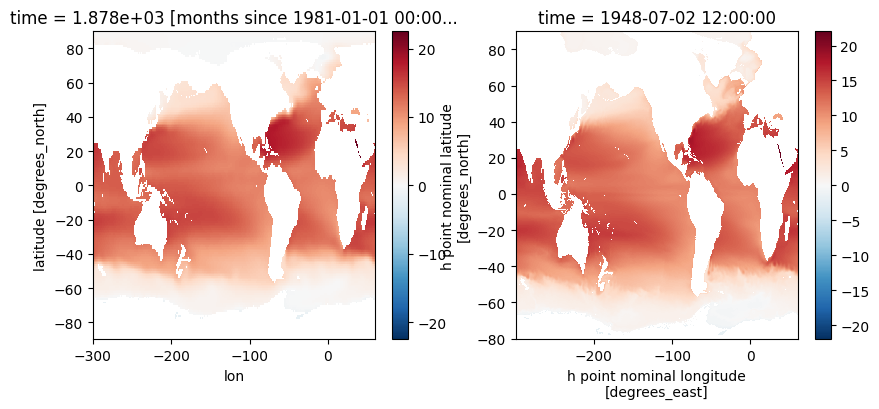

In [86]:
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
obs.plot()

plt.subplot(1,2,2)
control.plot()

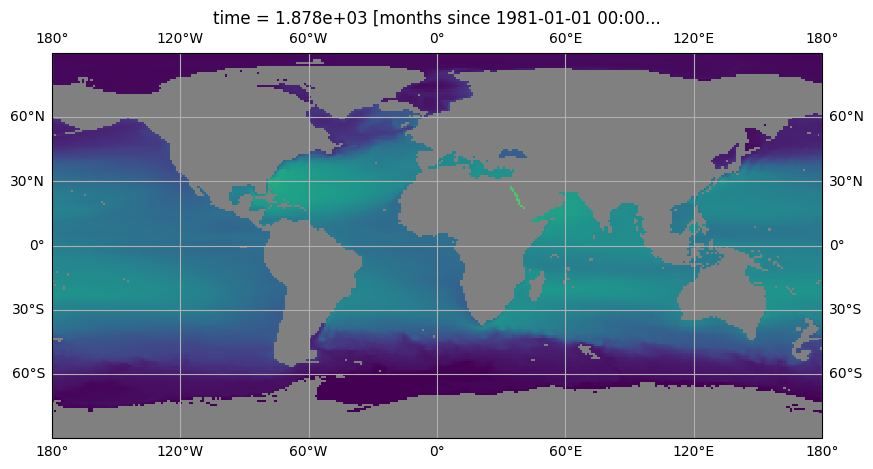

In [87]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
regridder_nearest(control).plot.pcolormesh(ax=ax, rasterized=True, cmap='viridis', vmin=0, vmax=30, add_colorbar=False)
ax.gridlines(draw_labels=True)
#ax.coastlines()
ax.set_facecolor('gray')
ax.set_ylim([-90,90])
plt.savefig('test2.pdf')

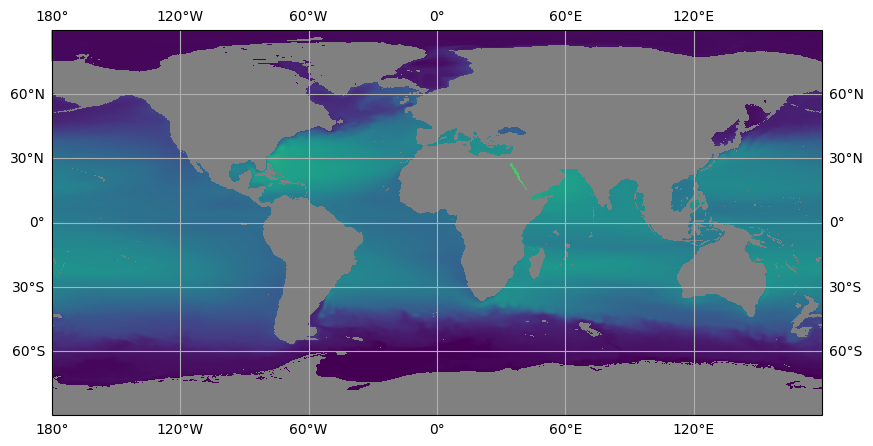

In [88]:
fig = plt.figure(figsize=(10, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.pcolormesh(param.geolon, param.geolat,control, rasterized=True, cmap='viridis', vmin=0, vmax=30)
ax.gridlines(draw_labels=True)
#ax.coastlines()
ax.set_facecolor('gray')
ax.set_ylim([-90,90])
plt.savefig('test3.pdf')

# Final figures with 60-years runs

In [92]:
from matplotlib.patches import Rectangle
def plot_sst(control, parameterized, obs, label, regions={}, global_rmse=False, obs_text='WOA18'):    
    
    plot_no=[1,2]
    
    fig = plt.figure(figsize=(15,5), layout='constrained')
    plt.rcParams['font.size'] = 20
    plt.rcParams['axes.titlesize'] = 20

    x, y = obs['lon'], obs['lat']
    lon,lat=np.meshgrid(x,y)
        
    for i in plot_no:
        
        ax = fig.add_subplot(1, 2, i, projection=ccrs.PlateCarree(central_longitude=60))
        gl = gridlines = ax.gridlines(draw_labels=True, linewidth=0.5,alpha=1.0, linestyle='-')
        gl.xtop_labels = False
        gl.xlabels_top = False
        gl.ylabels_right = False  
        
        if i==1:
            data = control - obs  ### load the data to be plotted
            rmse = float(np.around(np.sqrt(np.nanmean(data**2)),2))
            
            cmap = plt.cm.RdYlBu_r
            
            #vmin,vmax,ci = -2.25,2.25,0.5
            vmin,vmax,ci = -0.9,0.9,0.2
            cilev = np.arange(vmin,vmax+ci,ci)
            
            pcm=ax.contourf(lon,lat,data, transform=ccrs.PlateCarree(),cmap=cmap, levels=cilev, extend='both')
            pcm.set_rasterized(True)

            if global_rmse:
                ax.set_title(f'Control - {obs_text}, global RMSE='+str(rmse)+'$\degree $C')
            else:
                ax.set_title(f'Control - {obs_text}')

            for key, val in regions.items():
                lon_range, lat_range, color = val
                regional_rmse = float(np.around(np.sqrt(np.nanmean(data.sel(lon=slice(*lon_range), lat=slice(*lat_range))**2)),2))
                rect = Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                                 linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=100)
                ax.add_patch(rect)
                ax.text(lon_range[0] + 1, lat_range[0] - 15, f'RMSE={regional_rmse}$\degree $C', color=color, fontsize=12,
                                 transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=1.0, edgecolor=color), zorder=100)
                
        elif i==2:
            gl.ylabels_left = False  
            
            data = parameterized[0].data - control.data  ### load the data to be plotted
            cmap = plt.cm.RdYlBu_r

            error = parameterized[0] - obs  ### load the data to be plotted
            rmse = float(np.around(np.sqrt(np.nanmean(error**2)),2))
            
            #vmin,vmax,ci = -2.25,2.25,0.5
            vmin,vmax,ci = -0.9,0.9,0.2
            cilev = np.arange(vmin,vmax+ci,ci)
            
            pcm=ax.contourf(lon,lat,data, transform=ccrs.PlateCarree(),cmap=cmap, levels=cilev, extend='both')
            pcm.set_rasterized(True)
            if global_rmse:
                ax.set_title(f'{label[0]} - Control, global RMSE='+str(rmse)+'$\degree $C')
            else:
                ax.set_title(f'{label[0]} - Control')

            for key, val in regions.items():
                lon_range, lat_range, color = val
                regional_rmse = float(np.around(np.sqrt(np.nanmean(error.sel(lon=slice(*lon_range), lat=slice(*lat_range))**2)),2))
                rect = Rectangle((lon_range[0], lat_range[0]), lon_range[1] - lon_range[0], lat_range[1] - lat_range[0],
                                 linewidth=2, edgecolor=color, facecolor='none', transform=ccrs.PlateCarree(), zorder=100)
                ax.add_patch(rect)
                ax.text(lon_range[0] + 1, lat_range[0] - 15, f'RMSE={regional_rmse}$\degree $C', color=color, fontsize=12,
                                 transform=ccrs.PlateCarree(), bbox=dict(facecolor='white', alpha=1.0, edgecolor=color), zorder=100)
            
        ax.set_facecolor('gray')
        ax.coastlines(rasterized=True)
    
    cbar = plt.colorbar(pcm, ax=plt.gca().axes, orientation='vertical', shrink=0.7)
    cbar.set_label('1981-2007 and 0-750m \naveraged pot. temperature [$\degree $C]', fontsize=16)
    cbar.ax.xaxis.set_tick_params(labelrotation=45)

In [90]:
obs = sort_longitude(obs, -120)
rcontrol = sort_longitude(regridder_nearest(control),-120).drop_vars(['lon','lat'])
rann = sort_longitude(regridder_nearest(ann),-120).drop_vars(['lon','lat'])

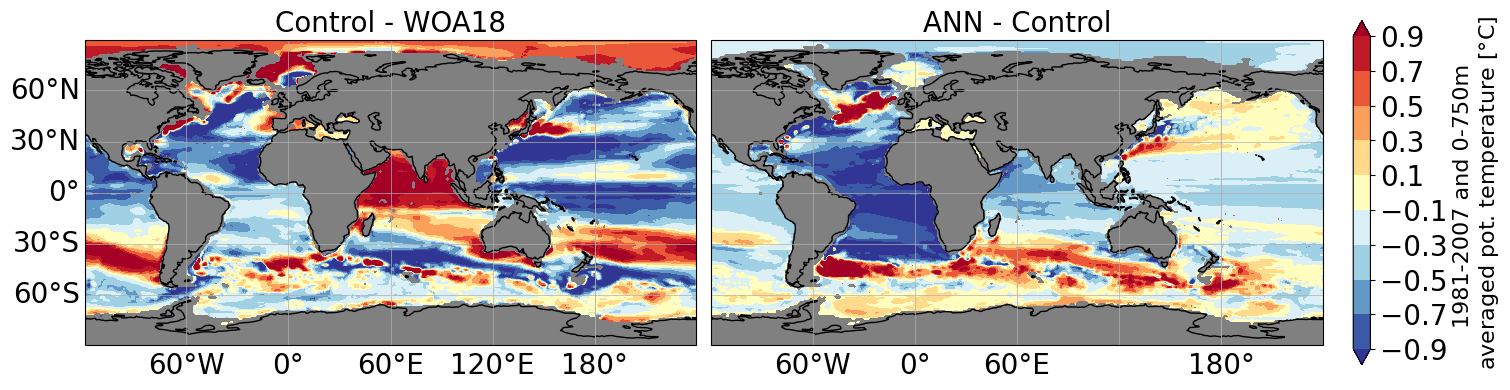

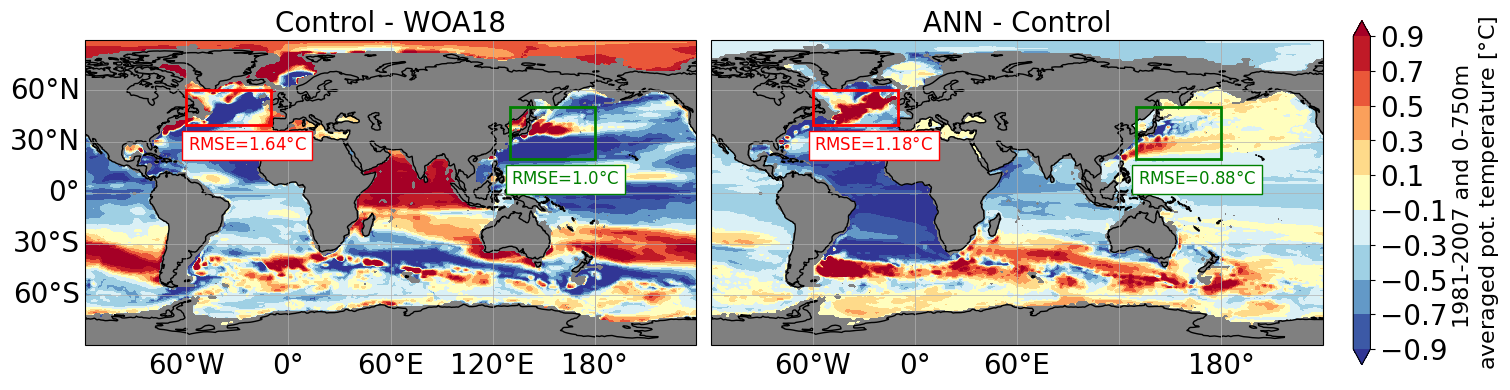

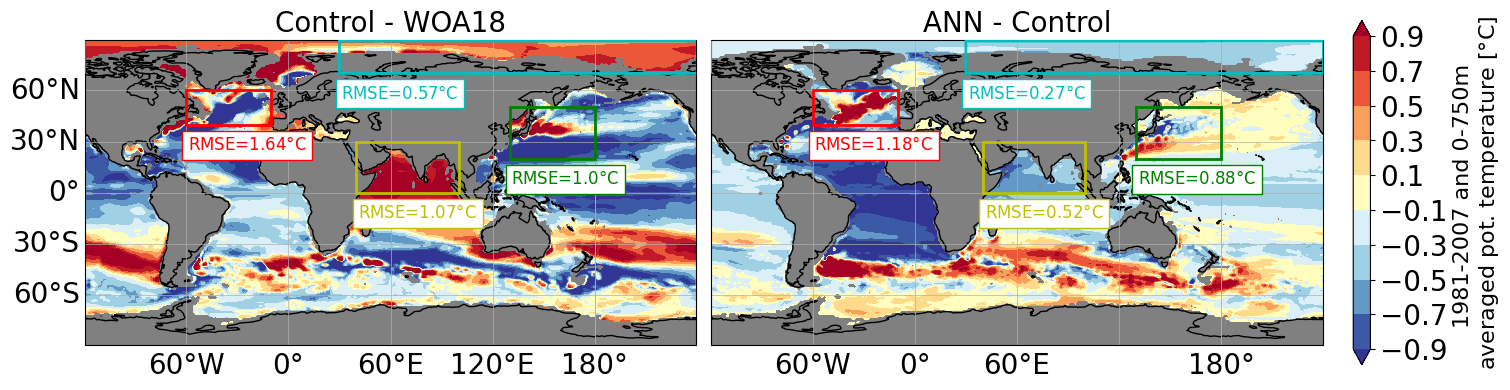

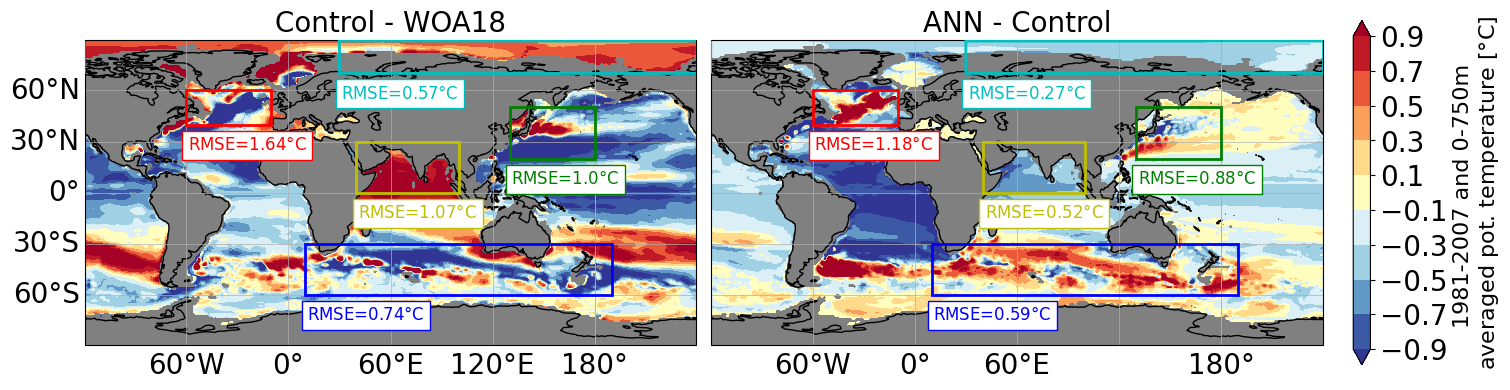

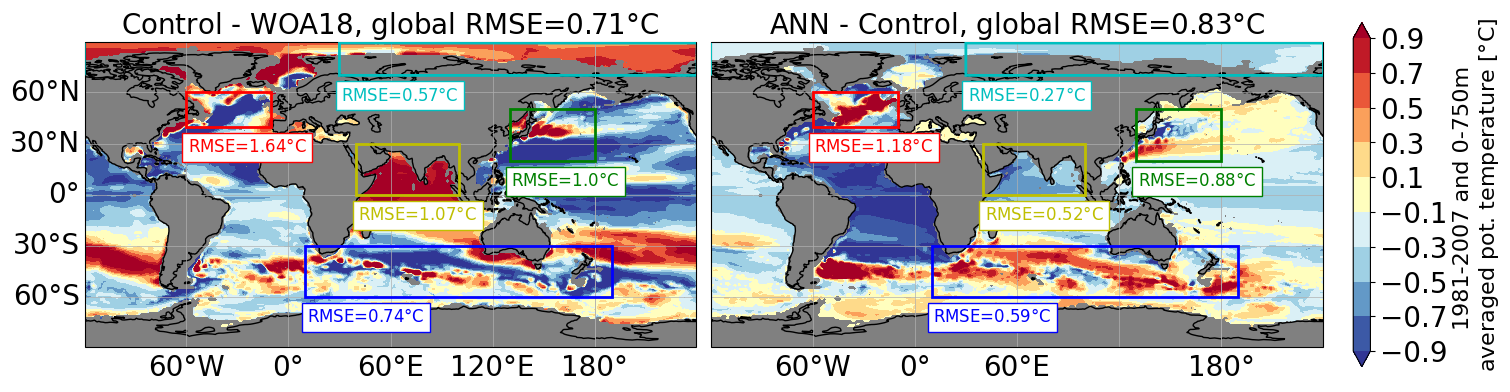

In [91]:
regions={'Kuroshio': ((130,180), (20, 50), 'g'),
         'Gulf': ((-60,-10), (40, 60), 'r'),
         'ACC': ((10,190), (-60, -30), 'b'),
         'Indian': ((40,100), (0, 30), 'y'),
         'Arctic': ((30,-120+360), (70, 89), 'c')}

plot_sst(rcontrol, [rann], obs, label=['ANN'])
plt.savefig('Figures-OM4/global.pdf', bbox_inches='tight', dpi=100)

plot_sst(rcontrol, [rann], obs, label=['ANN'], regions = {k: v for k, v in regions.items() if k in ['Kuroshio', 'Gulf']})
plt.savefig('Figures-OM4/WBC.pdf', bbox_inches='tight', dpi=100)

plot_sst(rcontrol, [rann], obs, label=['ANN'], regions = {k: v for k, v in regions.items() if k in ['Kuroshio', 'Gulf', 'Indian', 'Arctic']})
plt.savefig('Figures-OM4/WBC-Indian-Arctic.pdf', bbox_inches='tight', dpi=100)

plot_sst(rcontrol, [rann], obs, label=['ANN'], regions=regions)
plt.savefig('Figures-OM4/all.pdf', bbox_inches='tight', dpi=100)

plot_sst(rcontrol, [rann], obs, label=['ANN'], regions=regions, global_rmse=True)
plt.savefig('Figures-OM4/all-global-rmse.pdf', bbox_inches='tight', dpi=100)

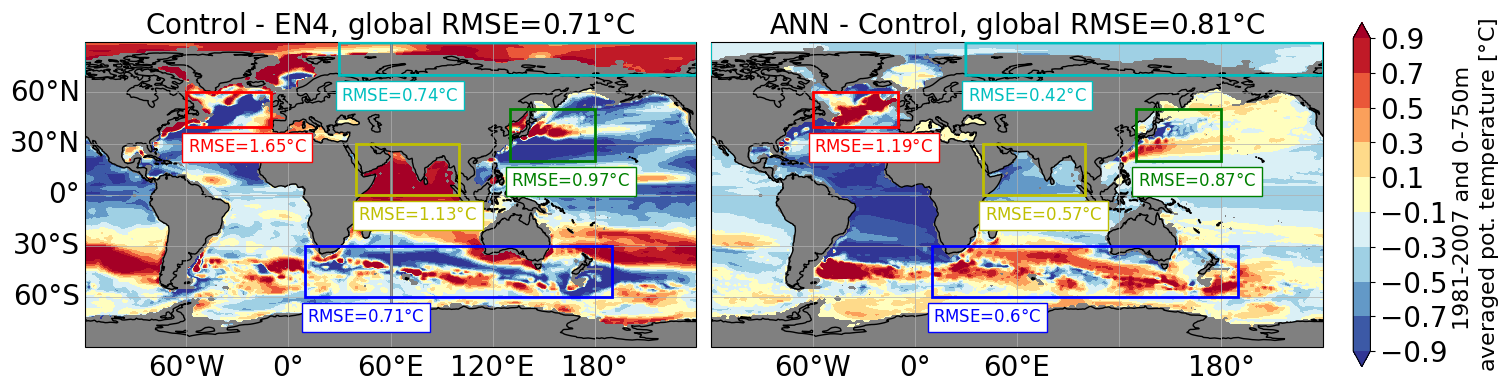

In [93]:
obs_en4 = sort_longitude(obs_en4, -120)
plot_sst(rcontrol, [rann], obs_en4, label=['ANN'], regions=regions, global_rmse=True, obs_text='EN4')
plt.savefig('Figures-OM4/all-global-rmse-EN4.pdf', bbox_inches='tight', dpi=100)

Text(0.5, 1.0, '1981-2007 and 0-750m \naveraged pot. temperature [$\\degree $C]')

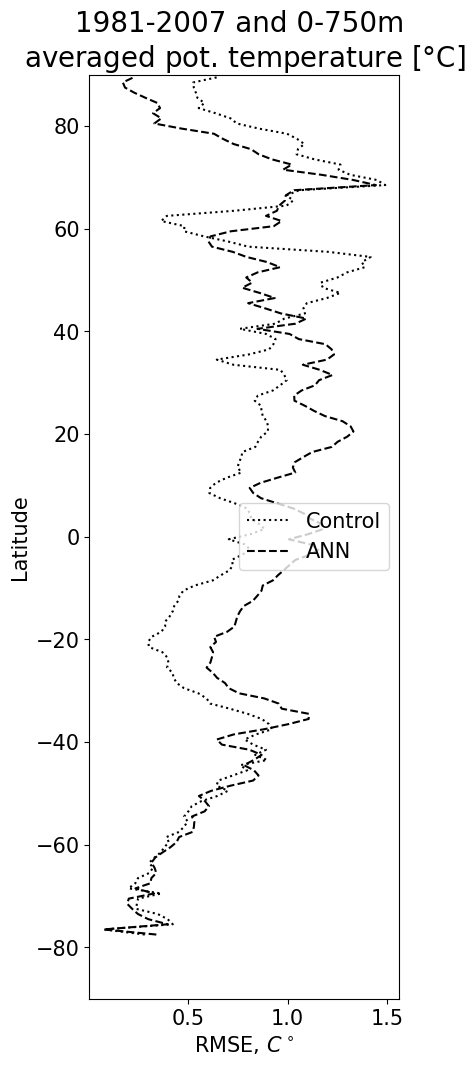

In [23]:
plt.figure(figsize=(4,12))
plt.rcParams['font.size'] = 15
for data, label, ls in zip([rcontrol, rann], ['Control', 'ANN'], [':', '--']):
    error = np.sqrt(((data - obs)**2).mean('lon'))
    error.plot(y='lat', color='k', ls=ls,label=label)    
plt.xlabel('RMSE, $C^\circ$')
plt.ylabel('Latitude')
plt.ylim([-90,90])
plt.legend(loc='center right')
plt.title('1981-2007 and 0-750m \naveraged pot. temperature [$\degree $C]')
#plt.savefig('Figures-Dec/SST-bias-lat.pdf', bbox_inches='tight')

Text(0.5, 1.0, '1981-2007 and 0-750m \naveraged pot. temperature [$\\degree $C]')

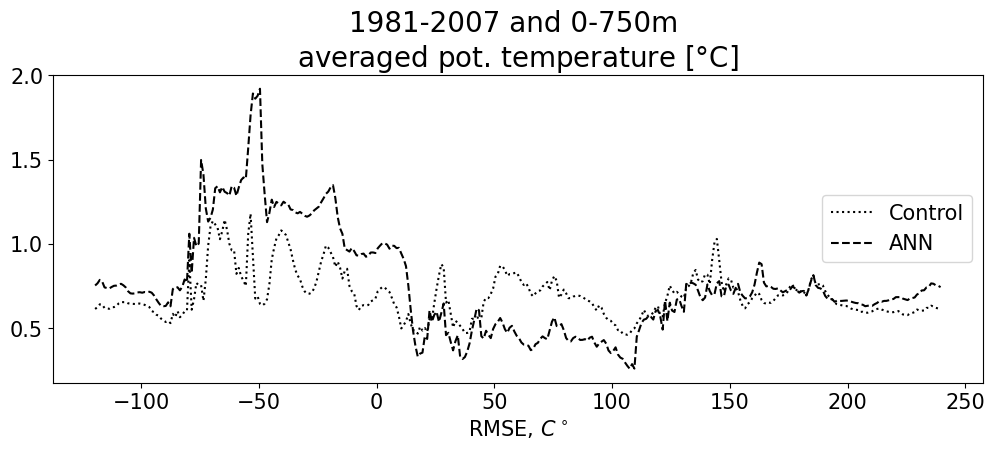

In [24]:
plt.figure(figsize=(12,4))
plt.rcParams['font.size'] = 15
for data, label, ls in zip([rcontrol, rann], ['Control', 'ANN'], [':', '--']):
    error = np.sqrt(((data - obs)**2).mean('lat'))
    error.plot(x='lon', color='k', ls=ls,label=label)    
plt.xlabel('RMSE, $C^\circ$')
#plt.ylabel('Latitude')
#plt.ylim([-90,90])
plt.legend(loc='center right')
plt.title('1981-2007 and 0-750m \naveraged pot. temperature [$\degree $C]')
#plt.savefig('Figures-Dec/SST-bias-lat.pdf', bbox_inches='tight')